In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import keras
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import save_model

from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-07-26 09:35:18.535592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753522518.706518      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753522518.758791      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:

train_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
valid_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'

batch_size = 16
img_height = 224
img_width = 224

In [ ]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,width_shift_range=0.2,
    height_shift_range=0.2,rotation_range=25)

test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
)

test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size
)


valid = test_data_gen.flow_from_directory(
    valid_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


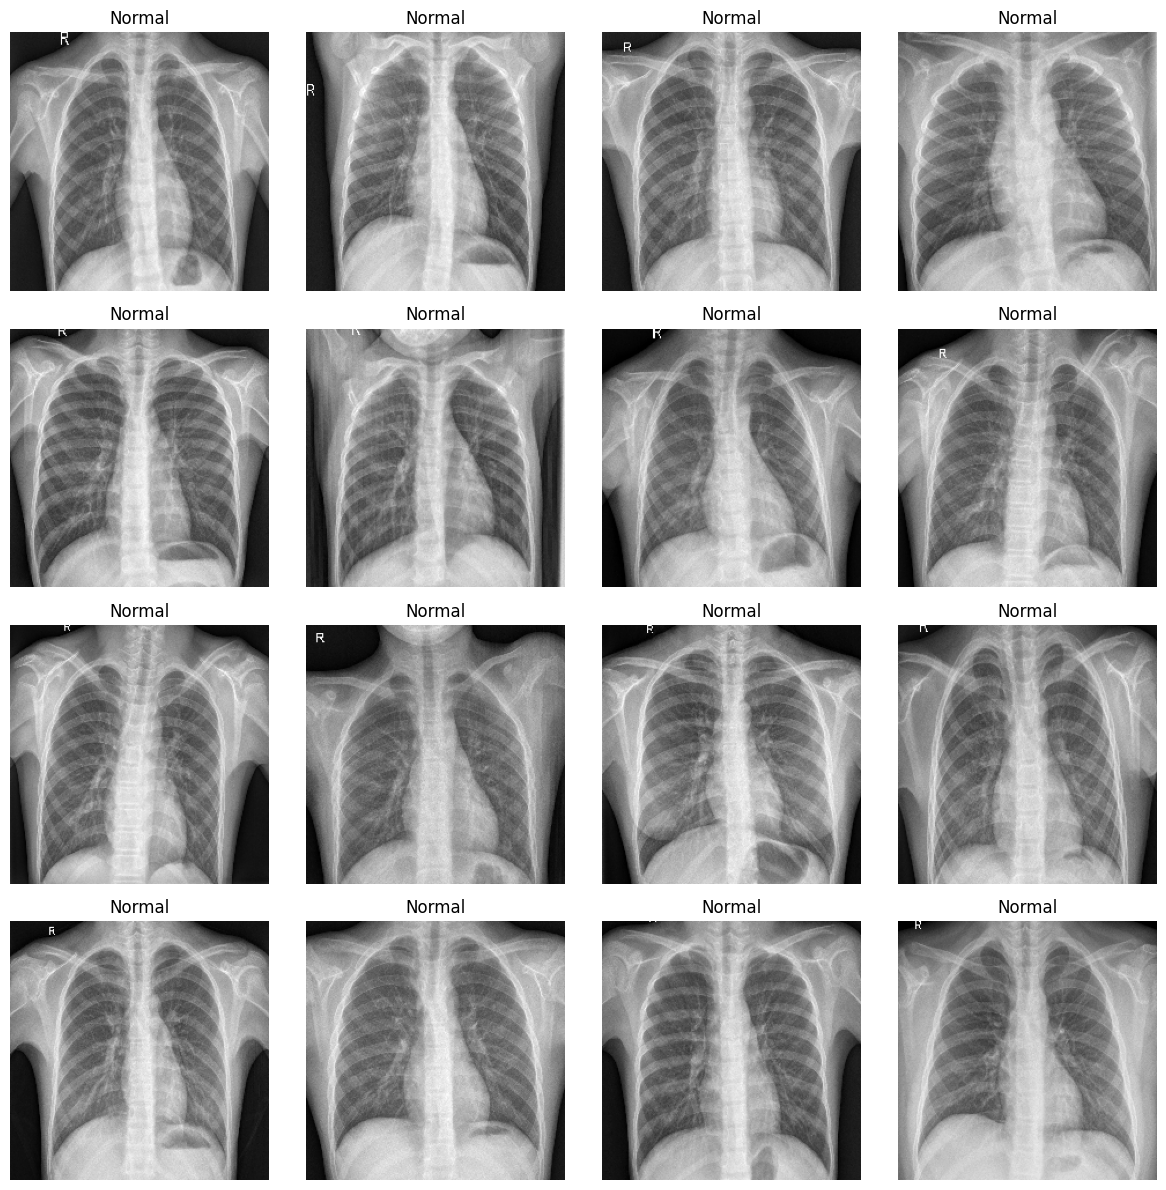

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(test)  
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i], cmap='gray')  
    plt.title("Pneumonia" if labels[i] == 1 else "Normal")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
model= Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))  

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,restore_best_weights=True
)


learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.3,
    min_lr=1e-6
)

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train.classes),
    y=train.classes
)

cw = dict(zip(np.unique(train.classes), weights))

In [26]:
history= model.fit(
    train,
    epochs=45,
    validation_data=valid,
    class_weight=cw,
    callbacks=[early,learning_rate_reduction]  
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/45


I0000 00:00:1753523310.652723     128 service.cc:148] XLA service 0x7eb88c00e940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753523310.653489     128 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753523310.653511     128 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753523311.046373     128 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/326 ━━━━━━━━━━━━━━━━━━━━ 38:46 7s/step - accuracy: 0.1875 - loss: 0.6355

I0000 00:00:1753523314.476021     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 233ms/step - accuracy: 0.5441 - loss: 0.6017 - val_accuracy: 0.6875 - val_loss: 0.5927 - learning_rate: 0.0010
Epoch 2/45
326/326 ━━━━━━━━━━━━━━━━━━━━ 49s 150ms/step - accuracy: 0.8184 - loss: 0.3866 - val_accuracy: 0.8125 - val_loss: 0.4673 - learning_rate: 0.0010
Epoch 3/45
326/326 ━━━━━━━━━━━━━━━━━━━━ 49s 150ms/step - accuracy: 0.8428 - loss: 0.3291 - val_accuracy: 0.8125 - val_loss: 0.3254 - learning_rate: 0.0010
Epoch 4/45
326/326 ━━━━━━━━━━━━━━━━━━━━ 49s 150ms/step - accuracy: 0.8580 - loss: 0.2947 - val_accuracy: 0.8750 - val_loss: 0.4235 - learning_rate: 0.0010
Epoch 5/45
326/326 ━━━━━━━━━━━━━━━━━━━━ 49s 151ms/step - accuracy: 0.8804 - loss: 0.2633 - val_accuracy: 0.8125 - val_loss: 0.3336 - learning_rate: 0.0010
Epoch 6/45
326/326 ━━━━━━━━━━━━━━━━━━━━ 49s 150ms/step - accuracy: 0.8940 - loss: 0.2418 - val_accuracy: 0.8750 - val_loss: 0.2820 - learning_rate: 0.0010
Epoch 7/45
326/326 ━━━━━━━━━━━━━━━━━━━━ 50s 152ms/step - accuracy: 0.8929 - loss:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true = test.classes

y_pred_proba = model.predict(test, verbose=1)
y_pred = (y_pred_proba > 0.5).astype("int32").reshape(-1)

target_names = list(test.class_indices.keys())  # ['NORMAL', 'PNEUMONIA']

print(classification_report(y_true, y_pred, target_names=target_names))


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step
              precision    recall  f1-score   support

      NORMAL       0.82      0.82      0.82       234
   PNEUMONIA       0.89      0.89      0.89       390

    accuracy                           0.87       624
   macro avg       0.86      0.86      0.86       624
weighted avg       0.87      0.87      0.87       624



In [54]:
correct=np.sum(y_true==y_pred)
incorrect=np.sum(y_true!=y_pred)
print("correct : ",correct)
print("incorrect : ",incorrect)

correct :  541
incorrect :  83


([<matplotlib.patches.Wedge at 0x7eb8a42c7c10>,
 [Text(-1.091866367178034, -0.4203901000564152, 'correct'),
  Text(1.091866386857914, 0.4203900489424606, 'incorrect')],
 [Text(-0.6252568085549426, -0.24073621114341726, '86.7%'),
  Text(0.6252568198246173, 0.24073618187303297, '13.3%')])

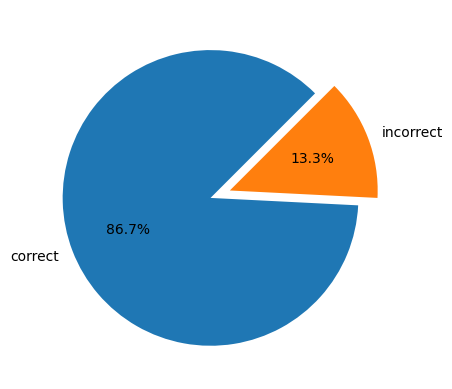

In [55]:
plt.pie(x=[correct,incorrect],labels=['correct','incorrect'],startangle=45,explode=[0.07,0.07],autopct='%1.1f%%')